In [1]:
from google.colab import files
uploaded = files.upload()

Saving dimredux-challenge-01-data.npz to dimredux-challenge-01-data (2).npz


## Prepare data


In [2]:
# !pip install -q tensorflow==2.0.0-alpha0
!pip install -q tensorflow-gpu==2.2.0

     |████████████████████████████████| 516.2MB 33kB/s 
     |████████████████████████████████| 460kB 87kB/s 
     |████████████████████████████████| 3.0MB 52.3MB/s 
ERROR: -ensorflow-gpu 1.14.0 has requirement tensorboard<1.15.0,>=1.14.0, but you'll have tensorboard 2.2.2 which is incompatible.
ERROR: -ensorflow-gpu 1.14.0 has requirement tensorflow-estimator<1.15.0rc0,>=1.14.0rc0, but you'll have tensorflow-estimator 2.2.0 which is incompatible.


In [0]:
from tensorflow.keras.layers import Dense, RepeatVector, TimeDistributed, SimpleRNN, Dropout, LeakyReLU
from tensorflow import keras
import tensorflow as tf
import numpy as np
from tqdm import tqdm, tqdm_notebook
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from itertools import permutations
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

In [4]:
with np.load('dimredux-challenge-01-data.npz') as fh:
        data_x = fh['data_x']
        validation_x = fh['validation_x']
        validation_y = fh['validation_y']

print(data_x.shape)
print(validation_x.shape)
print(validation_y.shape)

(100000, 3)
(1000, 3)
(1000,)


In [0]:
data_x = data_x.astype('float32')

original_data_x = np.copy(data_x)
TAU = 8

data_x = original_data_x[:-TAU]
shifted_data_x = original_data_x[TAU:]

In [6]:
print(f"original_data_x shape: {original_data_x.shape}")
print(f"data_x shape: {data_x.shape}")
print(f"shifted_data_x shape: {shifted_data_x.shape}")
print(f"validation_x shape: {validation_x.shape}")
print(f"validation_y shape: {validation_y.shape}")

original_data_x shape: (100000, 3)
data_x shape: (99992, 3)
shifted_data_x shape: (99992, 3)
validation_x shape: (1000, 3)
validation_y shape: (1000,)


## Visualize original data



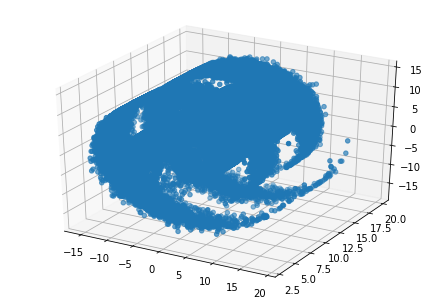

In [7]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(data_x[:, 0], data_x[:, 1], data_x[:, 2])
pyplot.show()

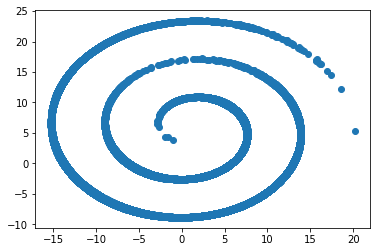

In [9]:

pca = PCA(n_components=2)
principal_components_original_x = pca.fit_transform(original_data_x)

plt.scatter(principal_components_original_x[:, 0], principal_components_original_x[:, 1])
plt.show()


## Visualize Validation Data

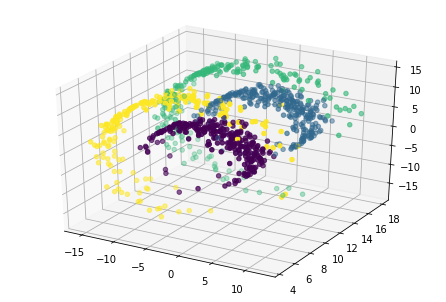

In [10]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(validation_x[:, 0], validation_x[:, 1], validation_x[:, 2], c=validation_y)
pyplot.show()

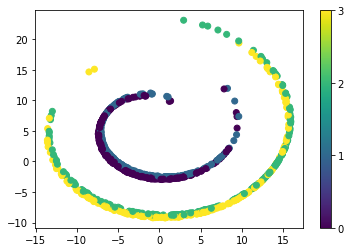

In [11]:
pca = PCA(n_components=2)
principal_components_validation_x = pca.fit_transform(validation_x)

plt.scatter(principal_components_validation_x[:, 0], principal_components_validation_x[:, 1], c=validation_y)
plt.colorbar(ticks=np.linspace(0,3,4))
plt.show()

## Whiten data

In [0]:
data_x = data_x - np.mean(data_x, axis=0)
shifted_data_x =  shifted_data_x - np.mean(shifted_data_x, axis=0)
original_data_x = original_data_x -  np.mean(original_data_x, axis=0)
validation_x = validation_x - np.mean(validation_x, axis=0)

In [0]:
pca_whiten = PCA(whiten=True)

data_x = pca_whiten.fit_transform(data_x)
shifted_data_x = pca_whiten.fit_transform(shifted_data_x)
original_data_x = pca_whiten.fit_transform(original_data_x)
validation_x = pca_whiten.fit_transform(validation_x)

## Visualize Tranform Data

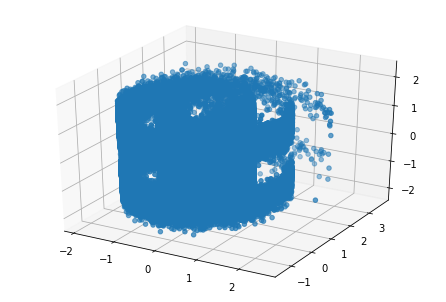

In [14]:

fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(data_x[:, 0], data_x[:, 1], data_x[:, 2])
pyplot.show()

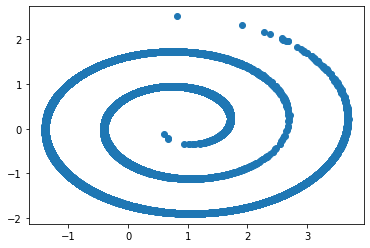

In [15]:
pca = PCA(n_components=2)
principal_components_data_x = pca.fit_transform(data_x)

plt.scatter(principal_components_data_x[:, 0], principal_components_data_x[:, 1])
plt.show()

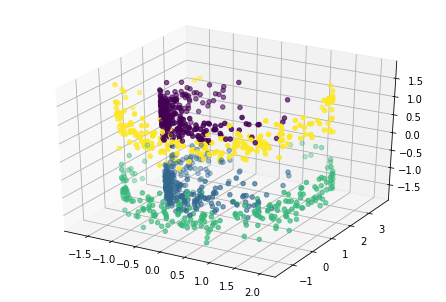

In [16]:

fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(validation_x[:, 0], validation_x[:, 1], validation_x[:, 2], c=validation_y)
pyplot.show()

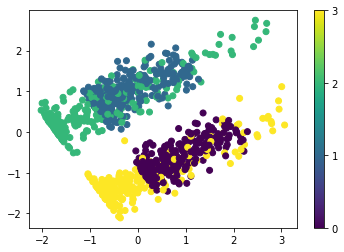

In [17]:
pca = PCA(n_components=2)
principal_components_validation_x = pca.fit_transform(validation_x)

plt.scatter(principal_components_validation_x[:, 0], principal_components_validation_x[:, 1], c=validation_y)
plt.colorbar(ticks=np.linspace(0,3,4))
plt.show()

# Prepare Model

In [0]:
data_x = np.expand_dims(data_x, axis=2)
shifted_data_x = np.expand_dims(shifted_data_x, axis=2)
original_data_x = np.expand_dims(original_data_x, axis=2)
validation_x = np.expand_dims(validation_x, axis=2)

In [0]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 128
EPOCHS = 120

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((data_x, shifted_data_x)).batch(BATCH_SIZE)

In [0]:
def get_model():
    encoder_input = keras.Input(shape=(3, 1), name='input')
    x = SimpleRNN(200, return_sequences = True)(encoder_input)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    x = SimpleRNN(100,return_sequences = True)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)


    x = SimpleRNN(1, name="hidden_state", return_sequences = False)(x)
    hidden_state = LeakyReLU()(x)


    encoder = keras.Model(encoder_input, hidden_state, name="encoder")

    x = RepeatVector(3)(hidden_state)

    x = SimpleRNN(100, return_sequences=True)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    x = SimpleRNN(200, return_sequences=True)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    decoder_output = TimeDistributed(Dense(1))(x)

    auto_encoder = keras.Model(encoder_input, decoder_output, name="auto_encoder")

    return auto_encoder, encoder

In [22]:
model, encoder = get_model()

model.summary()

print()

encoder.summary()

Model: "auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3, 1)]            0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 3, 200)            40400     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 3, 200)            0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 200)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 3, 100)            30100     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 3, 100)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 100)           

# Training Step

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
loss = tf.keras.losses.MeanSquaredError()

In [0]:
def get_accuracy(prediction, validation):
    """
    Function returns prediction accuracy value. We know only which data point belongs to which class, but we don't know 
    in whcih order data were labeled in validation set we need to check all combinations and take best one
    :param prediction: np.array(N,), preditions after clastering 
    :param validation:  np.array(N,) expected labels 
    :return: scalar, accuracy of predicted classes 
    """
    accuracies = []
    
    for permutation in permutations([0, 1, 2, 3]):
        current_validation_permutation = np.zeros_like(validation)
        c1, c2, c3, c4 = permutation
        
        current_validation_permutation[validation == 0] = c1
        current_validation_permutation[validation == 1] = c2
        current_validation_permutation[validation == 2] = c3
        current_validation_permutation[validation == 3] = c4
        
        difference = prediction - current_validation_permutation
        
        acc_val = (1 - np.count_nonzero(difference) / len(difference))
        
        accuracies.append(acc_val)
        
    return max(accuracies)

In [0]:
def get_classes_from_claster(data_points):
    return KMeans(n_clusters=4).fit(data_points).labels_

In [27]:
model.compile(optimizer=optimizer, loss=loss)
model.fit(dataset, epochs=EPOCHS, verbose=2)

Epoch 1/120
782/782 - 9s - loss: 0.9660
Epoch 2/120
782/782 - 10s - loss: 0.9507
Epoch 3/120
782/782 - 9s - loss: 0.9475
Epoch 4/120
782/782 - 9s - loss: 0.9423
Epoch 5/120
782/782 - 10s - loss: 0.9383
Epoch 6/120
782/782 - 10s - loss: 0.9340
Epoch 7/120
782/782 - 9s - loss: 0.9296
Epoch 8/120
782/782 - 10s - loss: 0.9269
Epoch 9/120
782/782 - 9s - loss: 0.9240
Epoch 10/120
782/782 - 11s - loss: 0.9214
Epoch 11/120
782/782 - 11s - loss: 0.9196
Epoch 12/120
782/782 - 9s - loss: 0.9173
Epoch 13/120
782/782 - 10s - loss: 0.9166
Epoch 14/120
782/782 - 9s - loss: 0.9151
Epoch 15/120
782/782 - 9s - loss: 0.9152
Epoch 16/120
782/782 - 10s - loss: 0.9143
Epoch 17/120
782/782 - 9s - loss: 0.9136
Epoch 18/120
782/782 - 9s - loss: 0.9126
Epoch 19/120
782/782 - 10s - loss: 0.9119
Epoch 20/120
782/782 - 10s - loss: 0.9114
Epoch 21/120
782/782 - 10s - loss: 0.9111
Epoch 22/120
782/782 - 9s - loss: 0.9103
Epoch 23/120
782/782 - 9s - loss: 0.9108
Epoch 24/120
782/782 - 10s - loss: 0.9106
Epoch 25/120


In [28]:
one_d_projection = encoder.predict(validation_x)
predictions = get_classes_from_claster(one_d_projection)
acc_val = get_accuracy(predictions, validation_y)
print(f"Accuracy on validation dataset {acc_val}")

Accuracy on validation dataset 0.997


[]

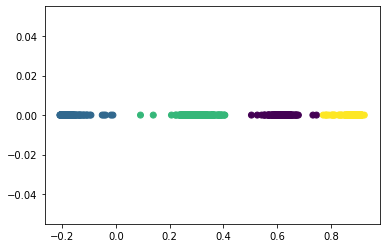

In [29]:
plt.scatter(one_d_projection, np.zeros_like(one_d_projection), c=predictions)
plt.plot()

In [0]:
model.save("autoencoder.h5")
encoder.save("encoder.h5")

In [0]:
np.save('prediction.npy', predictions)

In [35]:
print(predictions.shape,predictions.dtype)

(1000,) int32
